# License Plate Detection by Finding Contours
In this notebook, we show the overall implementation of License Plate Detection using the Contour method.

The contours are a useful tool for shape analysis and object detection and recognition. Using contour detection, we can detect the borders of objects, and therefore, localize them easily. Importantly, contour detection could be the very first step for many interesting applications such as image foreground extraction, simple image segmentation, detection and recognition.

## Import the necessary libraries

In [1]:
import os
import numpy as np # type: ignore
import pandas as pd
import cv2
import imutils
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
from sklearn.metrics import f1_score
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

## Load the image
In this step, we load an image that contains a car with its license plate.

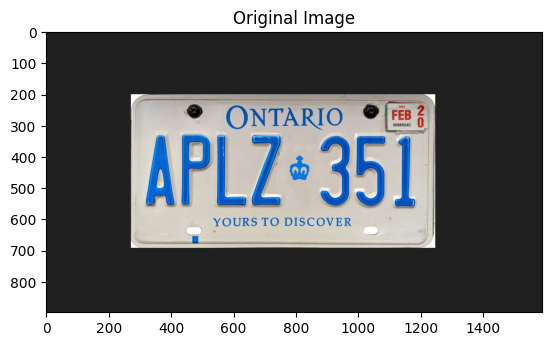

In [2]:
# Read the image file
image = cv2.imread('images/35.jpg')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.show()

## Finding Contours
In this, the image is first preprocessed and then sent for finding contours.
Image preprocessing contains the following steps:
- **Resizing the image**: Each image is resized to 500px width, to ease processing in the later stages.
- **Grayscale Conversion**: The input image is in RGB format. Main purpose of this conversion is to reduce the number of colors.
- **Noise Removal**: Image noises are distortion in the image that arises due to fault in camera or result of poor visibility due to changing weather conditions. Noises are also the random variation in the intensity levels of the pixels. Noise can be of various types like Gaussian noise, Salt and pepper noise. We used iterative bilateral filter for noise removal. It provides the mechanism for noise reduction while preserving edges more effectively than median filter.
- **Binarization**: Binarization is the process of converting an image into an image with two pixels value only i.e. containing white and black pixels. Performing binarization process before detecting and extracting license plate from the image will make the task of detecting license plate easier as edges will be more clearly in binary image.

After this, the image is ready to find contours.
Initially, all contours are found by using ```cv2.findContours()``` methods. All the contours with area less than 30 are discarded and the remaining contours are send for further processing. Each contour is approximated to form a polygon and if a contour is quadrilateral in shape (has 4 sides), then it is predicted to be the number plate and the contours are drawn using ```cv2.drawContours()``` method.

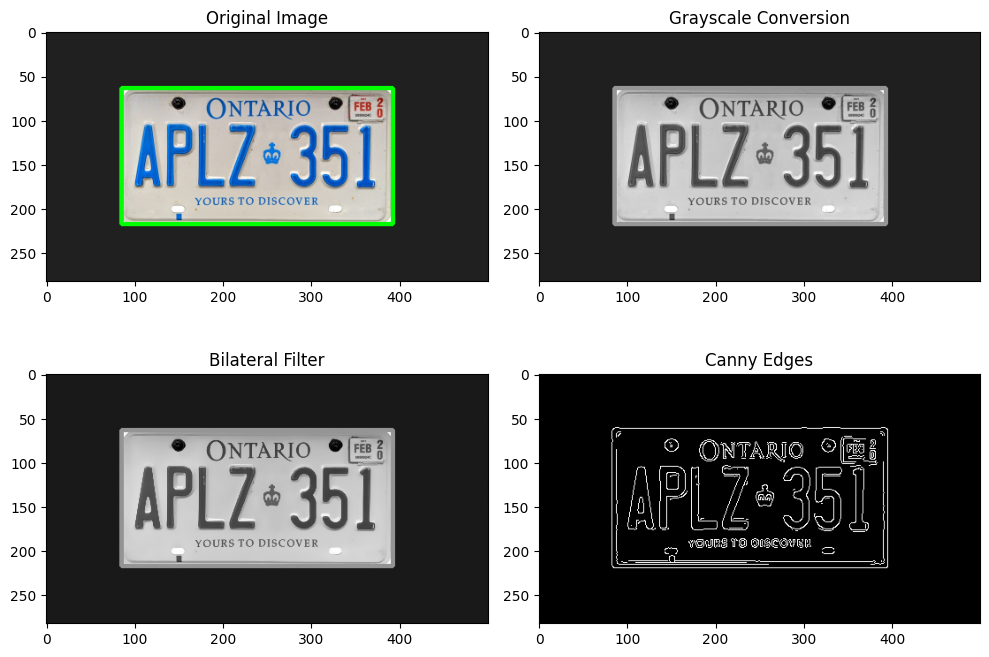

In [4]:
image = imutils.resize(image, width=500)
img=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the original image
fig, ax = plt.subplots(2, 2, figsize=(10,7))
ax[0,0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax[0,0].set_title('Original Image')

# RGB to Gray scale conversion
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ax[0,1].imshow(gray, cmap='gray')
ax[0,1].set_title('Grayscale Conversion')

# Noise removal with iterative bilateral filter(removes noise while preserving edges)
gray = cv2.bilateralFilter(gray, 11, 17, 17)
ax[1,0].imshow(gray, cmap='gray')
ax[1,0].set_title('Bilateral Filter')

# Find Edges of the grayscale image
edged = cv2.Canny(gray, 170, 200)
ax[1,1].imshow(edged, cmap='gray')
ax[1,1].set_title('Canny Edges')

fig.tight_layout()
plt.show()

# Find contours based on Edges
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
cnts=sorted(cnts, key = cv2.contourArea, reverse = True)[:30] #sort contours based on their area keeping minimum required area as '30' (anything smaller than this will not be considered)
NumberPlateCnt = None #we currently have no Number plate contour

# loop over our contours to find the best possible approximate contour of number plate
count = 0
for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:  # Select the contour with 4 corners
            NumberPlateCnt = approx #This is our approx Number Plate Contour
            x,y,w,h = cv2.boundingRect(c)
            ROI = img[y:y+h, x:x+w]
            break

if NumberPlateCnt is not None:
    # Drawing the selected contour on the original image
    cv2.drawContours(image, [NumberPlateCnt], -1, (0,255,0), 3)

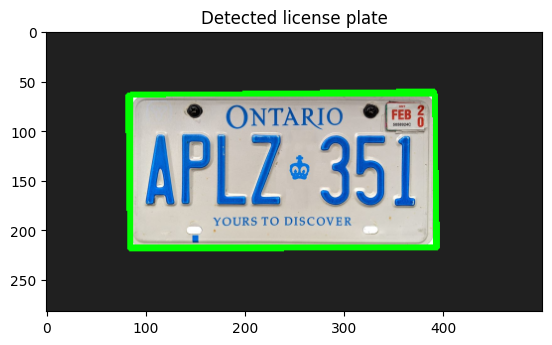

In [5]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Detected license plate")
plt.show()

The green bounding box shows the detected license plate.

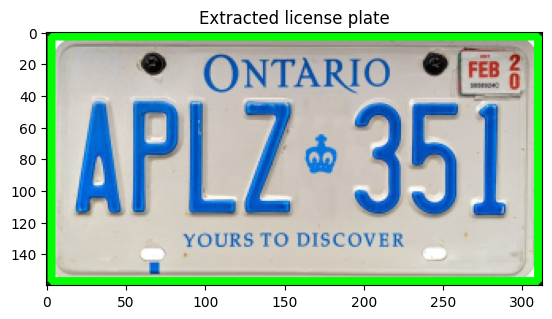

In [6]:
# Find bounding box and extract ROI
plt.imshow(ROI)
plt.title("Extracted license plate")
plt.show()

## Rotate the plate (if tilted)
This step is useful if the extracted license plate is tilted/rotated. It might arise problems in the character segmentation phase, so it is better to straighten it.

In [8]:
print(NumberPlateCnt)

[[[ 82  64]]

 [[ 84 219]]

 [[394 218]]

 [[391  60]]]


The above displayed coordinates are the coordinates of the detected plate. But the problem is that we don't know which coordinate is where, because contours can start from anywhere and form a continuous path.

The idea behind plate rotation is to find the bottom two coordinates. Using these two coordinates, we can easily find the angle of rotation. This will be illustrated shortly.

In [9]:
# Distance between (x1, y1) and (x2, y2)
def dist(x1, x2, y1, y2):
    return ((x1-x2)**2+(y1-y2)**2)**0.5

The above function returns the Euclidean distance between any two points (x1, y1) and (x2, y2).

As discussed, we need to find the bottom two coordinates:
- To find them, we'll first find a coordinate with the maximum y-coordinate and this will be one of the two bottom-most coordinates.
- Now, the other bottom coordinate will be either to the left or right of this coordinate in the array. Since, license plates are rectangular in shape, the second required coordinate would be in a distance far away from the acquired coordinate than the other adjacent coordinate.

In [10]:
idx=0
m=0
# To find the index of coordinate with maximum y-coordinate
for i in range(4):
    if NumberPlateCnt[i][0][1]>m:
        idx=i
        m=NumberPlateCnt[i][0][1]

# Assign index to the previous coordinate
if idx==0:
    pin=3
else:
    pin=idx-1

# Assign index to the next coordinate
if idx==3:
    nin=0
else:
    nin=idx+1

# Find distances between the acquired coordinate and its previous and next coordinate
p=dist(NumberPlateCnt[idx][0][0], NumberPlateCnt[pin][0][0], NumberPlateCnt[idx][0][1], NumberPlateCnt[pin][0][1])
n=dist(NumberPlateCnt[idx][0][0], NumberPlateCnt[nin][0][0], NumberPlateCnt[idx][0][1], NumberPlateCnt[nin][0][1])

# The coordinate that has more distance from the acquired coordinate is the required second bottom-most coordinate
if p>n:
    if NumberPlateCnt[pin][0][0]<NumberPlateCnt[idx][0][0]:
        left=pin
        right=idx
    else:
        left=idx
        right=pin
    d=p
else:
    if NumberPlateCnt[nin][0][0]<NumberPlateCnt[idx][0][0]:
        left=nin
        right=idx
    else:
        left=idx
        right=nin
    d=n
print(left, right)

1 2


Extract the coordinates of the bottom-most coordinates in such a way that ```(left_x, left_y)``` denote the bottom-left coordinate and ```(right_x, right_y)``` denote the bottom-right coordinate.

In [11]:
left_x=NumberPlateCnt[left][0][0]
left_y=NumberPlateCnt[left][0][1]
right_x=NumberPlateCnt[right][0][0]
right_y=NumberPlateCnt[right][0][1]
print(left_x, left_y, right_x, right_y)

84 219 394 218


For rotating the plate, we need to find the angle of rotation. This can be found out by calculating the sin of theta using the two coordinates. Theta can then be extracted by finding the inverse of sin. Image can finally be rotated by using ```cv2.getRotationMatrix2D()``` function.

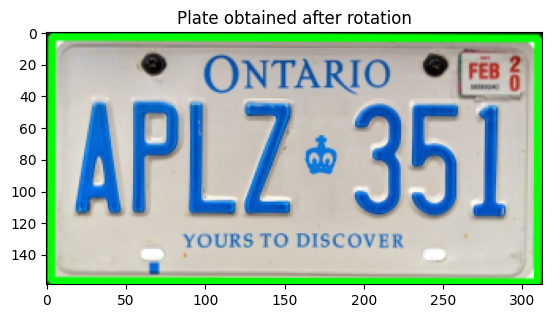

In [12]:
# Finding the angle of rotation by calculating sin of theta
opp=right_y-left_y
hyp=((left_x-right_x)**2+(left_y-right_y)**2)**0.5
sin=opp/hyp
theta=math.asin(sin)*57.2958

# Rotate the image according to the angle of rotation obtained
image_center = tuple(np.array(ROI.shape[1::-1]) / 2)
rot_mat = cv2.getRotationMatrix2D(image_center, theta, 1.0)
result = cv2.warpAffine(ROI, rot_mat, ROI.shape[1::-1], flags=cv2.INTER_LINEAR)

# The image can be cropped after rotation( since rotated image takes much more height)
if opp>0:
    h=result.shape[0]-opp//2
else:
    h=result.shape[0]+opp//2

result=result[0:h, :]
plt.imshow(result)
plt.title("Plate obtained after rotation")
plt.show()

## Character Segmentation
Character segmentation is an operation that seeks to decompose an image of a sequence of characters into subimages of individual symbols. It is one of the decision processes in a system for optical character recognition (OCR).

This phase contains the use of two functions: ```segment_characters()``` and ```find_contours()```.

In [13]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')
            plt.title('Predict Segments')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In the above function, we will be applying some more image processing to extract the individual characters from the license plate. The steps involved will be:
- Finding all the contours in the input image. The function cv2.findContours returns all the contours it finds in the image.
- After finding all the contours we consider them one by one and calculate the dimension of their respective bounding rectangle. Now consider bounding rectangle is the smallest rectangle possible that contains the contour. All we need to do is do some parameter tuning and filter out the required rectangle containing required characters. For this, we will be performing some dimension comparison by accepting only those rectangle that have:
  1. Width in the range 0, (length of the pic)/(number of characters) and,
  2. Length in a range of (width of the pic)/2, 4*(width of the pic)/5. After this step, we should have all the characters extracted as binary images.

In [14]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.title('Contour')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

The above function takes in the image as input and performs the following operation on it:
- Resizes it to a dimension such that all characters seem distinct and clear.
- Convert the colored image to a gray scaled image. We do this to prepare the image for the next process.
- Now the threshold function converts the grey scaled image to a binary image i.e each pixel will now have a value of 0 or 1 where 0 corresponds to black and 1 corresponds to white. It is done by applying a threshold that has a value between 0 and 255, here the value is 200 which means in the grayscaled image for pixels having a value above 200, in the new binary image that pixel will be given a value of 1. And for pixels having value below 200, in the new binary image that pixel will be given a value of 0.
- The image is now in binary form and ready for the next process Eroding. Eroding is a simple process used for removing unwanted pixels from the object’s boundary meaning pixels that should have a value of 0 but are having a value of 1.
- The image is now clean and free of boundary noise, we will now dilate the image to fill up the absent pixels meaning pixels that should have a value of 1 but are having value 0.
- The next step now is to make the boundaries of the image white. This is to remove any out of the frame pixel in case it is present.
- Next, we define a list of dimensions that contains 4 values with which we’ll be comparing the character’s dimensions for filtering out the required characters.
- Through the above processes, we have reduced our image to a processed binary image and we are ready to pass this image for character extraction.

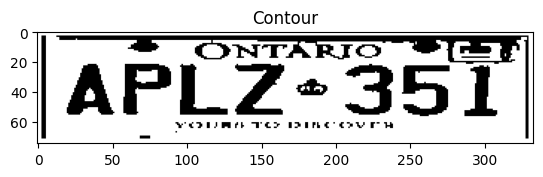

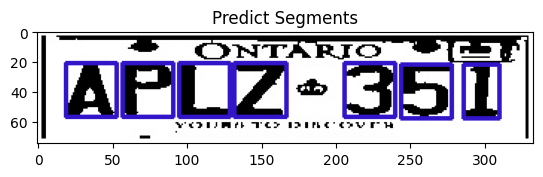

In [15]:
char=segment_characters(result)

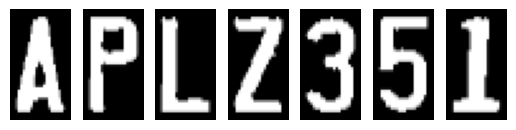

In [16]:
for i in range(len(char)):
    plt.subplot(1, len(char), i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')
plt.show()

## Character Recognition using CNN
Since the data is all clean and ready, now it’s time do create a Neural Network that will be intelligent enough to recognize the characters after training. In this project, we used CNN model for character recognition.
- For training the model, we’ll be using ImageDataGenerator class available in keras to generate some more data using image augmentation techniques like width shift, height shift.
- Width shift: Accepts a float value denoting by what fraction the image will be shifted left and right.
- Height shift: Accepts a float value denoting by what fraction the image will be shifted up and down.

In [17]:
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = 'data'
train_generator = train_datagen.flow_from_directory(
        path+'/data/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        color_mode='grayscale',
        class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(
        path+'/data/val',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28 batch_size=1,
        color_mode='grayscale',
        class_mode='sparse')

Found 863 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


For the model, we'll use 4 convolutional layers with a Max pooling layer of window size = (4,4). We'll also use 2 Dense layers where the last dense layers will have 36 output units (26 alphabets + 10 digits) and the activation function used will be 'softmax' because this is a multi-classification problem.

The below parameters used in the model have already been optimized using hyperparamter tuning.

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

K.clear_session()

model = Sequential()

# Reduced filters and kernel sizes to minimize parameters
model.add(Conv2D(4, (3,3), activation='relu', padding='same', input_shape=(28, 28, 1)))  # Only 2 filters
model.add(MaxPooling2D(pool_size=(2,2)))  # Small pooling to retain features

model.add(Conv2D(2, (3,3), activation='relu', padding='same'))  # 4 filters only
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(2, (3,3), activation='relu', padding='same'))  # 4 filters only
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())  # No more convolution layers to reduce computation

# Minimized Dense Layer
model.add(Dense(18, activation='relu'))  # Reduced dense layer neurons
model.add(Dense(36, activation='softmax'))  # Output layer for classification

# Compile with sparse categorical cross-entropy
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])

model.summary()



c:\Users\16773\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 4)      │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 2)      │            74 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 2)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 2)        │            38 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 2)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 36)             │           684 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,178 (4.60 KB)

 Trainable params: 1,178 (4.60 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 4)      │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 2)      │            74 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 2)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 2)        │            38 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 2)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 36)             │           684 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,178 (4.60 KB)

 Trainable params: 1,178 (4.60 KB)

 Non-trainable params: 0 (0.00 B)

We'll now go ahead and test our model. Note that the attribute ```steps_per_epoch``` is set to be ```train_generator.samples // batch_size``` because it ensures the usage of all the train data for one epoch.

In [20]:
batch_size = 1
result = model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      epochs = 25, verbose=1, callbacks=None)

Epoch 1/25


c:\Users\16773\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


863/863 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.0363 - loss: 3.5806 - val_accuracy: 0.0833 - val_loss: 3.5164
Epoch 2/25
863/863 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1057 - loss: 3.3306 - val_accuracy: 0.2454 - val_loss: 2.5436
Epoch 3/25
863/863 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2658 - loss: 2.4075 - val_accuracy: 0.3519 - val_loss: 2.1580
Epoch 4/25
863/863 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4035 - loss: 1.9450 - val_accuracy: 0.4028 - val_loss: 1.9023
Epoch 5/25
863/863 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4543 - loss: 1.7319 - val_accuracy: 0.4722 - val_loss: 1.6371
Epoch 6/25
863/863 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4892 - loss: 1.5406 - val_accuracy: 0.5463 - val_loss: 1.4909
Epoch 7/25
863/863 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5514 - loss: 1.4009 - val_accuracy: 0.5602 - val_loss: 1.3345
Epoch 8/25
863/863 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5986 - loss: 1.3563 - val_accuracy: 0.5417 - val_

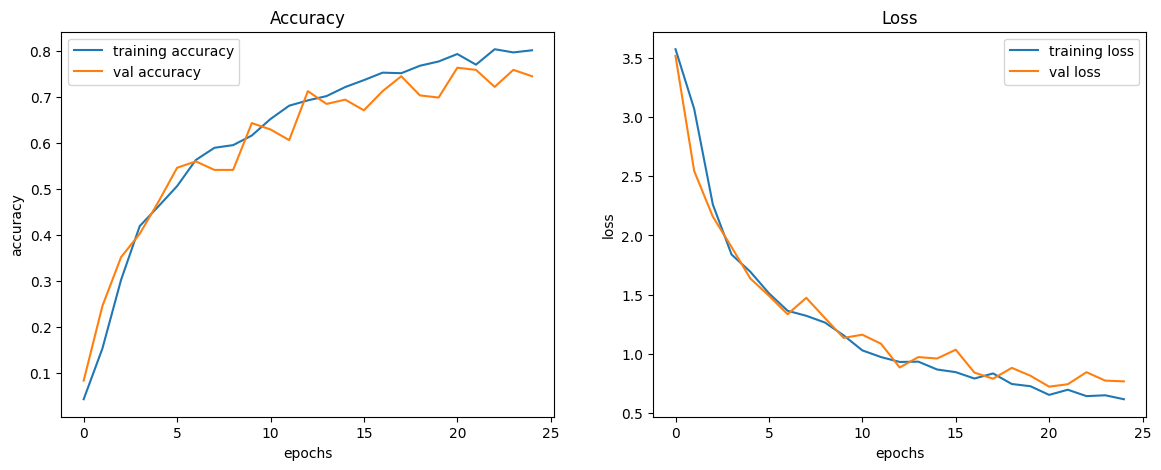

In [21]:
fig = plt.figure(figsize=(14,5))
grid=gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.plot(result.history['accuracy'], label='training accuracy')
plt.plot(result.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

fig.add_subplot(grid[1])
plt.plot(result.history['loss'], label='training loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

Save the model weights for future use.

In [22]:

# Save the weights
model.save_weights('./checkpoints/my_checkpoint.weights.h5')
def to_twos_complement(value, bits=8):
    if value < 0:
        value = (1 << bits) + value  # Convert negative to two's complement
    return format(value, f'0{bits}b')  # Convert to binary with leading zeros

# Function to save weights and biases in .mem format
def save_weights_as_verilog(layer_name, weights, biases):
    weight_file = f"{layer_name}_weights.mem"
    bias_file = f"{layer_name}_biases.mem"

    # Save Weights
    with open(weight_file, "w") as f:
        for w in weights.flatten():
            fixed_w = int(w * 256)  # Convert to 8-bit fixed-point representation
            fixed_w = max(-128, min(127, fixed_w))  # Clamp values to -128 to 127 range
            f.write(f"{to_twos_complement(fixed_w, 8)}\n")  # Store in signed 8-bit

    # Save Biases
    with open(bias_file, "w") as f:
        for b in biases.flatten():
            fixed_b = int(b * 256)  # Convert to 8-bit fixed-point representation
            fixed_b = max(-128, min(127, fixed_b))  # Clamp values to -128 to 127 range
            f.write(f"{to_twos_complement(fixed_b, 8)}\n")  # Store in signed 8-bit

    print(f"Saved {layer_name} weights and biases to {weight_file} and {bias_file}")

# Process each layer in the CNN model
for layer in model.layers:
    weights = layer.get_weights()  # Extract weights & biases
    if len(weights) == 2:  # Ensure the layer has both weights and biases
        save_weights_as_verilog(layer.name, weights[0], weights[1])
    elif len(weights) == 1:  # If only weights exist (some layers may not have biases)
        save_weights_as_verilog(layer.name, weights[0], np.zeros(weights[0].shape[-1]))

print("All weights and biases have been saved in .mem format.")


Saved conv2d weights and biases to conv2d_weights.mem and conv2d_biases.mem
Saved conv2d_1 weights and biases to conv2d_1_weights.mem and conv2d_1_biases.mem
Saved conv2d_2 weights and biases to conv2d_2_weights.mem and conv2d_2_biases.mem
Saved dense weights and biases to dense_weights.mem and dense_biases.mem
Saved dense_1 weights and biases to dense_1_weights.mem and dense_1_biases.mem
All weights and biases have been saved in .mem format.


In [37]:
import h5py
import numpy as np

# Path to weights file and output text file
weights_path = './checkpoints/my_checkpoint.weights.h5'
output_txt = './checkpoints/model_parameters.txt'

with h5py.File(weights_path, 'r') as f:
    with open(output_txt, 'w') as txt_file:
        for layer_name in f['layers'].keys():  # Iterate through layers
            layer_group = f['layers'][layer_name]
            if 'vars' in layer_group:
                txt_file.write(f"Layer: {layer_name}\n")
                vars_group = layer_group['vars']
                for i, var_key in enumerate(vars_group.keys()):  # Iterate over weight/bias keys
                    param_values = np.array(vars_group[var_key])  # Convert to numpy array
                    txt_file.write(f"  Variable {i} (shape: {param_values.shape}):\n")
                    txt_file.write(f"{param_values.tolist()}\n\n")  # Convert to list for readability

print(f"Model parameters successfully saved in {output_txt}")


Model parameters successfully saved in ./checkpoints/model_parameters.txt


In [46]:
import numpy as np
model.save_weights('./checkpoints/my_checkpoint.weights.h5')
# Function to save weights and biases in .mem format
def save_weights_as_verilog(layer_name, weights, biases):
    weight_file = f"{layer_name}_weights.mem"
    bias_file = f"{layer_name}_biases.mem"

    # Save Weights
    with open(weight_file, "w") as f:
        for w in weights.flatten():
            # Save weight as regular fractional number with 7 decimal precision
            f.write(f"{w:.7f}\n")  # Format the weight as a float with 7 decimal places

    # Save Biases
    with open(bias_file, "w") as f:
        for b in biases.flatten():
            # Save bias as regular fractional number with 7 decimal precision
            f.write(f"{b:.7f}\n")  # Format the bias as a float with 7 decimal places

    print(f"Saved {layer_name} weights and biases to {weight_file} and {bias_file}")

# Process each layer in the CNN model
for layer in model.layers:
    weights = layer.get_weights()  # Extract weights & biases
    if len(weights) == 2:  # Ensure the layer has both weights and biases
        save_weights_as_verilog(layer.name, weights[0], weights[1])
    elif len(weights) == 1:  # If only weights exist (some layers may not have biases)
        save_weights_as_verilog(layer.name, weights[0], np.zeros(weights[0].shape[-1]))

print("All weights and biases have been saved in .mem format.")


Saved conv2d weights and biases to conv2d_weights.mem and conv2d_biases.mem
Saved conv2d_1 weights and biases to conv2d_1_weights.mem and conv2d_1_biases.mem
Saved conv2d_2 weights and biases to conv2d_2_weights.mem and conv2d_2_biases.mem
Saved dense weights and biases to dense_weights.mem and dense_biases.mem
Saved dense_1 weights and biases to dense_1_weights.mem and dense_1_biases.mem
All weights and biases have been saved in .mem format.


In [39]:
import numpy as np

# Function to convert a float to fixed-point (Q0.7 format)
def float_to_fixed_point(val, bits=8, frac_bits=7):
    # Scale the floating point value to fixed-point
    scaled_value = int(round(val * (2 ** frac_bits)))  # Scale and round
    # Clip to the range of a signed 8-bit number
    scaled_value = max(min(scaled_value, (2 ** (bits - 1)) - 1), -(2 ** (bits - 1)))
    return scaled_value

# Function to save weights and biases in .mem format
def save_weights_as_verilog(layer_name, weights, biases):
    weight_file = f"{layer_name}_weights.mem"
    bias_file = f"{layer_name}_biases.mem"

    # Save Weights
    with open(weight_file, "w") as f:
        for w in weights.flatten():
            # Convert weight to fixed-point and save
            fixed_weight = float_to_fixed_point(w)
            f.write(f"{fixed_weight}\n")

    # Save Biases
    with open(bias_file, "w") as f:
        for b in biases.flatten():
            # Convert bias to fixed-point and save
            fixed_bias = float_to_fixed_point(b)
            f.write(f"{fixed_bias}\n")

    print(f"Saved {layer_name} weights and biases to {weight_file} and {bias_file}")

# Process each layer in the CNN model
for layer in model.layers:
    weights = layer.get_weights()  # Extract weights & biases
    if len(weights) == 2:  # Ensure the layer has both weights and biases
        save_weights_as_verilog(layer.name, weights[0], weights[1])
    elif len(weights) == 1:  # If only weights exist (some layers may not have biases)
        save_weights_as_verilog(layer.name, weights[0], np.zeros(weights[0].shape[-1]))

print("All weights and biases have been saved in .mem format.")


Saved conv2d weights and biases to conv2d_weights.mem and conv2d_biases.mem
Saved conv2d_1 weights and biases to conv2d_1_weights.mem and conv2d_1_biases.mem
Saved conv2d_2 weights and biases to conv2d_2_weights.mem and conv2d_2_biases.mem
Saved dense weights and biases to dense_weights.mem and dense_biases.mem
Saved dense_1 weights and biases to dense_1_weights.mem and dense_1_biases.mem
All weights and biases have been saved in .mem format.


Since we saved only the model weights, we first need to create a model instance and then load the saved weights into the model.

In [23]:
# Create a new model instance
loaded_model = Sequential()

loaded_model.add(Conv2D(4, (3,3), activation='relu', padding='same', input_shape=(28, 28, 1)))  # Only 2 filters
loaded_model.add(MaxPooling2D(pool_size=(2,2)))  # Small pooling to retain features

loaded_model.add(Conv2D(2, (3,3), activation='relu', padding='same'))  # 4 filters only
loaded_model.add(MaxPooling2D(pool_size=(2,2)))

loaded_model.add(Conv2D(2, (3,3), activation='relu', padding='same'))  # 4 filters only
loaded_model.add(MaxPooling2D(pool_size=(2,2)))

loaded_model.add(Flatten())  # No more convolution layers to reduce computation

# Minimized Dense Layer
loaded_model.add(Dense(18, activation='relu'))  # Reduced dense layer neurons
loaded_model.add(Dense(36, activation='softmax'))  # Output layer for classification




# Restore the weights
loaded_model.load_weights('checkpoints/my_checkpoint.weights.h5')
for layer in loaded_model.layers:
    print(layer.name, layer.get_weights())

# Define output file path
output_file = "model_weights.txt"

# Open the file in write mode
with open(output_file, "w") as f:
    for layer in loaded_model.layers:
        weights = layer.get_weights()  # Get weights and biases
        if len(weights) > 0:  # Skip layers without weights
            f.write(f"Layer: {layer.name}\n")
            for i, w in enumerate(weights):
                f.write(f"  Weights {i} (shape {w.shape}):\n")
                np.savetxt(f, w.flatten(), fmt="%.6f")  # Save in readable format
                f.write("\n")
    print(f"Model weights saved to {output_file}")







# Define function to convert to 8-bit signed integers (two's complement)
def quantize_to_8bit(value):
    """
    Convert floating-point values to 8-bit signed integer representation.
    - Scale to range (-128, 127)
    - Round and clip to 8-bit integer range
    """
    scaled_value = np.round(value * 127)  # Scale to [-128, 127]
    return np.clip(scaled_value, -128, 127).astype(np.int8)  # Ensure it's within 8-bit range

# Iterate through model layers and save weights in .mem files
for layer in loaded_model.layers:
    weights = layer.get_weights()
    if len(weights) > 0:  # Only process layers with weights
        weight_file = f"{layer.name}_weights.mem"
        bias_file = f"{layer.name}_biases.mem"

        # Save Weights
        with open(weight_file, "w") as wf:
            weight_values = quantize_to_8bit(weights[0])  # Convert weights
            for w in weight_values.flatten():
                wf.write(f"{w}\n")  # Save in decimal format

        # Save Biases (if available)
        if len(weights) > 1:  # Some layers may not have biases
            with open(bias_file, "w") as bf:
                bias_values = quantize_to_8bit(weights[1])  # Convert biases
                for b in bias_values.flatten():
                    bf.write(f"{b}\n")  # Save in decimal format

        print(f"Saved {layer.name} weights to {weight_file} and biases to {bias_file}")


conv2d_3 [array([[[[-0.302307  ,  0.58284074,  0.9242951 , -0.14585532]],

        [[-0.3069978 , -0.14317511,  0.19968693, -0.00336083]],

        [[-0.3531371 , -0.11609158, -0.15668033,  0.34605438]]],


       [[[ 0.52208894,  0.43510035,  0.43439984,  0.06602157]],

        [[-0.18860692, -0.17979148, -0.21938358,  0.34867075]],

        [[-0.56464964, -0.6835873 , -0.3862923 ,  0.9522149 ]]],


       [[[ 0.5110204 , -0.71766925, -0.1886243 ,  0.4837107 ]],

        [[-0.0049192 , -0.24980141, -0.29817843,  0.74681497]],

        [[ 0.19875157, -0.01420649, -0.449281  ,  1.0342475 ]]]],
      dtype=float32), array([0.3765632 , 0.14967412, 0.13477433, 0.01869625], dtype=float32)]
max_pooling2d_3 []
conv2d_4 [array([[[[ 0.16359644,  0.19178313],
         [ 0.30201325,  0.44186842],
         [-0.04511709, -0.4843894 ],
         [ 0.02230079,  0.6067541 ]],

        [[-0.09091216, -0.5433387 ],
         [ 0.17029741, -0.0100419 ],
         [ 0.26132518,  0.42610067],
         [ 0.086

In [72]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from PIL import Image

# Define the model architecture
loaded_model = Sequential()

loaded_model.add(Conv2D(4, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))  # First convolution layer
loaded_model.add(MaxPooling2D(pool_size=(2, 2)))  # MaxPooling

loaded_model.add(Conv2D(2, (3, 3), activation='relu', padding='same'))  # Second convolution layer
loaded_model.add(MaxPooling2D(pool_size=(2, 2)))

loaded_model.add(Conv2D(2, (3, 3), activation='relu', padding='same'))  # Third convolution layer
loaded_model.add(MaxPooling2D(pool_size=(2, 2)))

loaded_model.add(Flatten())  # Flatten layer to prepare for dense layer

# Minimized Dense Layer
loaded_model.add(Dense(18, activation='relu'))  # Reduced dense layer neurons
loaded_model.add(Dense(36, activation='softmax'))  # Output layer for classification

# Restore the weights
loaded_model.load_weights('checkpoints/my_checkpoint.weights.h5')

# Create a new model that outputs the activations of the first Conv2D layer
layer_name = 'conv2d'  # The name of the first convolutional layer
first_conv_layer_model = Model(inputs=loaded_model.input, outputs=loaded_model.get_layer(layer_name).output)

# Function to preprocess the input image
def preprocess_image(image_path):
    # Open the image and convert it to grayscale
    img = Image.open(image_path).convert('L')
    # Resize to 28x28 pixels
    img = img.resize((28, 28))
    # Convert image to numpy array
    img_array = np.array(img)
    # Normalize the pixel values to [0, 1]
    img_array = img_array / 255.0
    # Reshape to (28, 28, 1) for the model input
    img_array = img_array.reshape(1, 28, 28, 1)
    return img_array

# Function to predict the character and extract the intermediate feature map
def predict_and_get_feature_map(image_path):
    # Preprocess the image
    img_array = preprocess_image(image_path)
    # Get the feature map from the first convolutional layer
    feature_map = first_conv_layer_model.predict(img_array)
    # Make prediction using the loaded model
    prediction = loaded_model.predict(img_array)
    # Get the predicted class (max probability)
    predicted_class = np.argmax(prediction)
    return predicted_class, feature_map

# Test the recognition and extract the feature map with a sample image
input_image = 'data/data/train/class_0/class_0_15.jpg'  # Replace with your input image path
predicted_class, feature_map = predict_and_get_feature_map(input_image)
print(f'Predicted class: {predicted_class}')
print(f'Feature map shape: {feature_map.shape}')


AttributeError: The layer sequential_45 has never been called and thus has no defined input.

## Predict the license plate number
We now have our license plate and the CNN model ready! We just need to predict each character using the model. For this, we'll first fix the dimension of each character image using the function ```fix_dimension```, in which it converts an image to a 3-channel image. The image can then be sent to ```model.predict_classes()``` in order to get the predicted character.

In [28]:
# Predicting the output
def fix_dimension(img): 
    new_img = np.zeros((28,28,1))
    new_img[:,:,0] = img
    return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters

        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,1) #preparing image for the model
        y_ = np.argmax(loaded_model.predict(img), axis=-1)[0]  # predict model

        character = dic[y_]
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

print(show_results())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
APLZ38I


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

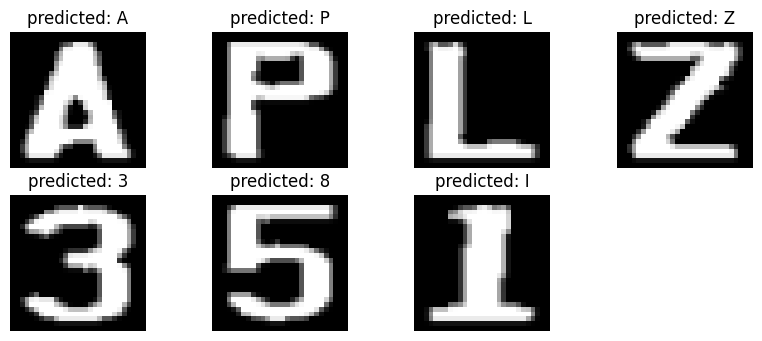

In [26]:
# Segmented characters and their predicted value.
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()

## Importing the dataset
We'll now import our dataset to calculate the overall accuracy of this method. The dataset contains about 200 images with a labels.xlsx that will be useful to check if the predicted output is correct

In [74]:
labels=pd.read_excel('test_dataset/labels.xlsx')
labels['ID']=labels['ID'].map(str)
labels

FileNotFoundError: [Errno 2] No such file or directory: 'test_dataset/labels.xlsx'

## Accuracy
We now need to run the whole code for all the images and calculate the accuracy.

In [28]:
file_list=os.listdir(r"test_dataset/images")
count=0
for path in file_list:
    no=path[:-4]
    row=labels['NUMBER'].where(labels['ID'] == no).dropna().values[0]
    image = cv2.imread('test_dataset/images/'+path)
    # Resize the image - change width to 500
    image = imutils.resize(image, width=500)
    img=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # RGB to Gray scale conversion
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Noise removal with iterative bilateral filter(removes noise while preserving edges)
    gray = cv2.bilateralFilter(gray, 11, 17, 17)

    # Find Edges of the grayscale image
    edged = cv2.Canny(gray, 170, 200)

    # Find contours based on Edges
    cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
    cnts=sorted(cnts, key = cv2.contourArea, reverse = True)[:30] #sort contours based on their area keeping minimum required area as '30' (anything smaller than this will not be considered)
    NumberPlateCnt = None #we currently have no Number plate contour

    # loop over our contours to find the best possible approximate contour of number plate
    for c in cnts:
            peri = cv2.arcLength(c, True)
            approx = cv2.approxPolyDP(c, 0.02 * peri, True)
            if len(approx) == 4:  # Select the contour with 4 corners
                NumberPlateCnt = approx #This is our approx Number Plate Contour
                x,y,w,h = cv2.boundingRect(c)
                ROI = img[y:y+h, x:x+w]
                break

    idx=0
    m=0
    if NumberPlateCnt is None:
        continue
    for i in range(4):
        if NumberPlateCnt[i][0][1]>m:
            idx=i
            m=NumberPlateCnt[i][0][1]
    if idx==0:
        pin=3
    else:
        pin=idx-1
    if idx==3:
        nin=0
    else:
        nin=idx+1

    p=dist(NumberPlateCnt[idx][0][0], NumberPlateCnt[pin][0][0], NumberPlateCnt[idx][0][1], NumberPlateCnt[pin][0][1])
    n=dist(NumberPlateCnt[idx][0][0], NumberPlateCnt[nin][0][0], NumberPlateCnt[idx][0][1], NumberPlateCnt[nin][0][1])

    if p>n:
        if NumberPlateCnt[pin][0][0]<NumberPlateCnt[idx][0][0]:
            left=pin
            right=idx
        else:
            left=idx
            right=pin
        d=p
    else:
        if NumberPlateCnt[nin][0][0]<NumberPlateCnt[idx][0][0]:
            left=nin
            right=idx
        else:
            left=idx
            right=nin
        d=n
    left_x=NumberPlateCnt[left][0][0]
    left_y=NumberPlateCnt[left][0][1]
    right_x=NumberPlateCnt[right][0][0]
    right_y=NumberPlateCnt[right][0][1]

    opp=right_y-left_y
    hyp=((left_x-right_x)**2+(left_y-right_y)**2)**0.5
    sin=opp/hyp
    theta=math.asin(sin)*57.2958

    image_center = tuple(np.array(ROI.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, theta, 1.0)
    result = cv2.warpAffine(ROI, rot_mat, ROI.shape[1::-1], flags=cv2.INTER_LINEAR)

    if opp>0:
        h=result.shape[0]-opp//2
    else:
        h=result.shape[0]+opp//2

    result=result[0:h, :]
    char=segment_characters(result)
    count=show_results(count)
print("Accuracy: "+str((count/166)*100)+"%")

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'test_dataset/images'